# A Comprehensive Guide on Learning Step-by-Step: Q-Learning and Deep Q-Learning

### Deep Q-Learning

In [4]:
import gymnasium as gym
import random
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn-v0_8-whitegrid')

In [121]:
class ActionValue(nn.Module):

    def __init__(self, n_states: int, n_actions: int, hidden_layers: int, hidden_size: int):

        '''
        A class that defines the network for the action-value function approximation

        Parameters:
        n_states: number of states
        n_actions: number of actions
        hidden_layers: number of hidden layers
        hidden_size: the size of the hidden layer

        '''
        super(ActionValue, self).__init__()

        layers = []
        layers.append(nn.Linear(n_states, hidden_size)) #input layer
        layers.append(nn.ReLU())

        for _ in range(hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_size, n_actions)) # output layer

        self.model = nn.Sequential(*layers)


    def forward(self, x):
        return self.model(x)

class Agent:
    def __init__(self, n_states: int, n_actions: int, memory_size: int, batch_size: int, alpha: float, gamma: float, epsilon: float, hidden_layers: int, hidden_size: int):
        '''
        The Agent class for Deep Q-learning.

        Parameters:
        n_states: number of states
        n_actions: number of actions
        memory_size: size fo the experience memory
        batch_size: size of the mini-batch
        alpha: learning rate for the optimizer
        gamma: discounting parameter
        epsilon: exploring probability
        hidden_size: the size of the hidden layer
        '''
        self.n_states = n_states
        self.n_actions = n_actions
        self.memory = deque(maxlen=memory_size)
        self.batch_size = batch_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        self.action_value = ActionValue(n_states, n_actions, hidden_layers, hidden_size)
        self.target = ActionValue(n_states, n_actions, hidden_layers, hidden_size)
        self.target.load_state_dict(self.action_value.state_dict())

        self.optimizer = optim.Adam(self.action_value.parameters(), lr=self.alpha)

    def behavior_policy(self, S: torch.tensor):
        
        if np.random.rand() <= self.epsilon:
            A = np.random.choice(self.n_actions)
        else:
            with torch.no_grad():
                Q = self.action_value(S)
                A = torch.argmax(Q).item()
                #print(f'Q:{Q}, A: {A}')

        return A

    def gradient_step(self):

        
        S, A, R, next_S, terminated, truncated = zip(*random.sample(self.memory, self.batch_size))

        S = torch.stack(S, dim=0).squeeze(1)
        #print(f'S : {S}')

        A = torch.tensor(A).view(-1,1)
        #print(f'A: {A}')

        #print(f'Q: {self.action_value(S)}')
        #print(f'Q gather: {self.action_value(S).gather(1, A)}')
        Q = self.action_value(S).gather(1, A).unsqueeze(0)
        #print(f'Q unsqueeze(0): {Q}')

        next_S = torch.stack(next_S, dim=0).squeeze(1)
        # print(f'next_Q: {self.target(next_S)}')
        next_Q = self.target(next_S)
        # print(f'next_Q max: {next_Q.max(1)}')
        # print(f'next_Q max [0]: {next_Q.max(1)[0]}')
        # print(f'next_Q max [0] unsqueeze(1): {next_Q.max(1)[0].unsqueeze(1)}')

        R = torch.tensor(R).view(-1,1)
        terminated = tuple(int(x) for x in terminated)
        terminated = torch.tensor(terminated).view(-1,1)

        truncated = tuple(int(x) for x in truncated)
        truncated = torch.tensor(truncated).view(-1,1)
        # print(f'R: {R}')
        #print(f'terminated: {terminated}')
        #print(f'truncated: {truncated}')

        target = R + (self.gamma * next_Q.max(1)[0].unsqueeze(1) * (1 - terminated) * (1 - truncated))

        #print(f'target: {target}')
        loss = nn.MSELoss()(Q, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
            
    def update_target_parameters(self):
        self.target.load_state_dict(self.action_value.state_dict())
        

def process_state(S: np.array, n_states: int):
    S = np.reshape(S, [1, n_states])
    S  = torch.tensor(S, dtype=torch.float32)
    return S
    

In [122]:
env = gym.make('CartPole-v1')
n_states = env.observation_space.shape[0]
n_actions = env.action_space.n
memory_size = 2000
batch_size = 64
gamma = 0.99
epsilon = 0.8
epsilon_decay = 0.9999
alpha = 0.01
hidden_layers = 1
hidden_size = 128
agent = Agent(n_states, n_actions, memory_size, batch_size, alpha, gamma, epsilon, hidden_layers, hidden_size)
n_episodes = 500
C = 20

R_hist = []

for episode in range(n_episodes):
    S, _ = env.reset()
    episode_R = 0
    step = 1
    while True:

        S = process_state(S, n_states)
        A = agent.behavior_policy(S)

        next_S, R, terminated, truncated, _ = env.step(A)
        episode_R += R
        next_S = process_state(next_S, n_states)
        agent.memory.append((S, A, R, next_S, terminated, truncated))
        S = next_S

        if len(agent.memory) > agent.batch_size:
            agent.gradient_step()
            
        if step % C == 0:
            agent.update_target_parameters()

        if terminated or truncated:
            print(f"episode {episode} score: {episode_R}")
            R_hist.append(episode_R)
            break
        step += 1
        agent.epsilon *= epsilon_decay

C:\Users\germa\AppData\Local\Temp\ipykernel_8440\3396174384.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  S  = torch.tensor(S, dtype=torch.float32)


episode 0 score: 10.0
episode 1 score: 10.0
episode 2 score: 62.0
episode 3 score: 11.0
episode 4 score: 20.0
episode 5 score: 14.0
episode 6 score: 10.0
episode 7 score: 20.0
episode 8 score: 15.0
episode 9 score: 11.0
episode 10 score: 15.0
episode 11 score: 14.0
episode 12 score: 20.0
episode 13 score: 15.0
episode 14 score: 18.0
episode 15 score: 15.0
episode 16 score: 17.0
episode 17 score: 18.0
episode 18 score: 14.0
episode 19 score: 22.0
episode 20 score: 58.0
episode 21 score: 27.0
episode 22 score: 20.0
episode 23 score: 65.0
episode 24 score: 17.0
episode 25 score: 70.0
episode 26 score: 18.0
episode 27 score: 13.0
episode 28 score: 26.0
episode 29 score: 50.0
episode 30 score: 29.0
episode 31 score: 45.0
episode 32 score: 13.0
episode 33 score: 105.0
episode 34 score: 24.0
episode 35 score: 20.0
episode 36 score: 34.0
episode 37 score: 24.0
episode 38 score: 21.0
episode 39 score: 13.0
episode 40 score: 15.0
episode 41 score: 48.0
episode 42 score: 40.0
episode 43 score: 43

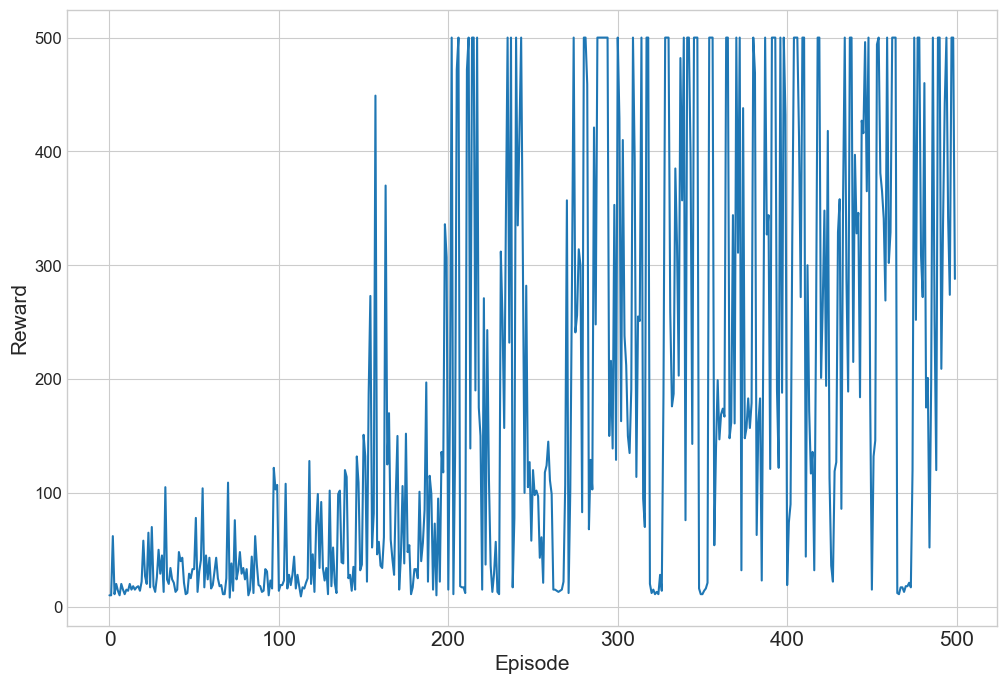

In [123]:
plt.plot(R_hist)
plt.xticks(fontsize=15)
plt.yticks(fontsize=12) 
plt.xlabel('Episode', fontsize=15)
plt.ylabel('Reward', fontsize=15)
plt.show()